## 0.1 Import Necessary Packages 

In [86]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from copy import copy 
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, OrthogonalMatchingPursuitCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

## 0.2 Import Raw Data, Clean Data, & Make Dataframes 

The data is taken from https://physionet.org/content/mimiciii/1.4/.
The data clearning code is taken (with slight adaptations) from https://github.com/daniel-codes/hospital-los-predictor/blob/master/hospital_los_prediction.ipynb

In [27]:
def mimic_los_cleanup(path_to_data='Length of Stay Data/', adm_csv='ADMISSIONS.csv', patients_csv='PATIENTS.csv',
                      diagcode_csv='DIAGNOSES_ICD.csv', icu_csv='ICUSTAYS.csv',
                      verbose=True):
    '''
    This function take 4 csv files from the MIMIC-III database, converts them to
    DataFrames for cleanup and feature engineering for use in a Length-of-Stay
    regression model such as the sklearn GradientBoostingRegressor. 
    
    INPUT:
    path_to_data - Data folder 
    adm_csv - Primary Admissions information
    patients_csv - Patient specific info such as gender and DOB
    diagcode_csv - ICD9 Diagnosis for each admission to hospital
    icu_csv - Intensive Care Unit (ICU) data for each admission 
    
    OUTPUT:
    df - clean DataFrame for use in an regression model
    actual_median_los - Median LOS for all admissions 
    actual_mean_los - Average LOS for all admissions
    '''
    
    # Import CSV tables
    df = pd.read_csv(path_to_data+adm_csv)
    df_pat = pd.read_csv(path_to_data+patients_csv)
    df_diagcode = pd.read_csv(path_to_data+diagcode_csv)
    df_icu = pd.read_csv(path_to_data+icu_csv)
    if verbose: 
           print('(1/5) Completed .csv imports')
        
    # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
    # Convert timedelta type into float 'days', 86400 seconds in a day
    df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400
    
    # Drop columns that are not needed for next steps
    df.drop(columns=['DISCHTIME', 'ROW_ID', 
                    'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                    'HAS_CHARTEVENTS_DATA'], inplace=True)
    
    # Track patients who died at the hospital by admission event
    df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})
    
    # Hospital LOS metrics
    actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
    actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 
    
    # Compress the number of ethnicity categories
    df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
    df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
    df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
    df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
    df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                             'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
    df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

    # Reduce categories to terms of religious or not
    df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

    # Re-categorize NaNs into 'Unknown'
    df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)') 
    
    if verbose: 
        print('(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.')
        
    # Feature Engineering for ICD9 code categories
    # Filter out E and V codes since processing will be done on the numeric first 3 values
    df_diagcode['recode'] = df_diagcode['ICD9_CODE']
    df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
    df_diagcode['recode'].fillna(value='999', inplace=True)
    df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
    df_diagcode['recode'] = df_diagcode['recode'].astype(int)
    
    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
                   (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
                   (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

    # Associated category names
    diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
                 4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
                 8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
                 12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
                 16: 'injury', 17: 'misc'}

    # Re-code in terms of integer
    for num, cat_range in enumerate(icd9_ranges):
        df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
                num, df_diagcode['recode'])

    # Convert integer to category name using diag_dict
    df_diagcode['recode'] = df_diagcode['recode']
    df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)
    
    # Create list of diagnoses for each admission
    hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
    # Convert diagnoses list into hospital admission-item matrix
    hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
    
    # Join back with HADM_ID, will merge with main admissions DF later
    hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

    # Merge with main admissions df
    df = df.merge(hadm_item, how='inner', on='HADM_ID')
    
    if verbose: 
        print('(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.')
    
    # Feature Engineering for Age and Gender
    # Convert to datetime type
    df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])
    df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
    df = df.merge(df_pat, how='inner', on='SUBJECT_ID')
    
    # Find the first admission time for each patient
    df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
    df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
    df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')
    
    # Age is decode by finding the difference in admission date and date of birth
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
    df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days / 365, axis=1)
    df['age'] = np.where(df['age'] < 0, 90, df['age'])
    df['age'] = np.where(df['age'] > 89, 90, df['age'])
    plt.hist(df['age'], bins=20, color='#c44e52')
    plt.ylabel('Count')
    plt.xlabel('Age (years)')
    plt.title('Distribution of Age in MIMIC-III')
    plt.tick_params(left=False, bottom=False, top=False, right=False) 
    plt.show();
    # Create age categories
    age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
    for num, cat_range in enumerate(age_ranges):
        df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
                num, df['age'])
    age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
    df['age'] = df['age'].replace(age_dict)
#     print(df['age'].describe())
    # Re-map Gender to boolean type
    df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
    
    if verbose: 
        print('(4/5) Completed PATIENT.csv cleanup and feature engineering.')
    
    # Feature engineering for Intensive Care Unit (ICU) category
    # Reduce ICU categories to just ICU or NICU
    df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
    df_icu['cat'] = df_icu['FIRST_CAREUNIT']
    icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
    icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
    icu_item[icu_item >= 1] = 1
    icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
    df = df.merge(icu_item, how='outer', on='HADM_ID')
    # Cleanup NaNs
    df['ICU'].fillna(value=0, inplace=True)
    df['NICU'].fillna(value=0, inplace=True)
    
    if verbose: 
        print('(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.')
        # Remove deceased persons as they will skew LOS result
    df = df[df['DECEASED'] == 0]

    # Remove LOS with negative number, likely entry form error
    df = df[df['LOS'] > 0]    
    
    # Drop unused columns, e.g. not used to predict LOS
    df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED', 'DEATHTIME'], inplace=True)
    
    prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'MAR']
    dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
                 'ETHNICITY', 'MARITAL_STATUS']
    prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
    dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
                 'ETHNICITY', 'age', 'MARITAL_STATUS']
    df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
    
    if verbose: 
        print('Data Preprocessing complete.')
    
    return df, actual_median_los, actual_mean_los

(1/5) Completed .csv imports


C:\Users\osarwar\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.
(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.


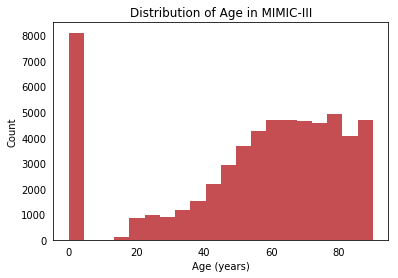

(4/5) Completed PATIENT.csv cleanup and feature engineering.
(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.
Data Preprocessing complete.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58975
Data columns (total 49 columns):
LOS                           53104 non-null float64
blood                         53104 non-null uint8
circulatory                   53104 non-null uint8
congenital                    53104 non-null uint8
digestive                     53104 non-null uint8
endocrine                     53104 non-null uint8
genitourinary                 53104 non-null uint8
infectious                    53104 non-null uint8
injury                        53104 non-null uint8
mental                        53104 non-null uint8
misc                          53104 non-null uint8
muscular                      53104 non-null uint8
neoplasms                     53104 non-null uint8
nervous                       53104 non-null uint8
pregnancy              

(53104, 49)

In [28]:
# Clean Data 
df, actual_median_los, actual_mean_los = mimic_los_cleanup()
df.info()
df.shape
# df.to_pickle("originalLOSdf.pkl")

## 0.1.1 More Feature Engineering

In [32]:
##Eliminate newborns 
# df = df[df["AGE_newborn"] == 0]
# df = df.drop(columns=["AGE_newborn", "ADM_NEWBORN"])
# df.to_pickle("originalLOSdf_nonewborn.pkl")

In [51]:
#load from pickle 
df = pd.read_pickle("originalLOSdf.pkl")
# df = pd.read_pickle("originalLOSdf_nonewborn.pkl")
df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,1.144444,0,1,0,0,0,0,0,4,1,...,0,1,0,0,0,1,0,0,0,0
1,5.496528,0,4,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,6.768056,0,2,0,0,2,0,0,3,0,...,0,1,0,0,0,1,0,0,0,0
3,2.856944,0,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3.534028,0,3,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [52]:
# Separate Response and Predictor Variables 
Response = df["LOS"]
Predictors = df.iloc[:, 1:]
# Training and Testing Data Split 
X_train, X_test, y_train, y_test = train_test_split(Predictors, Response, random_state=22)

# 1.0 Data Analysis 

## 1.1 Correlation Heatmap 

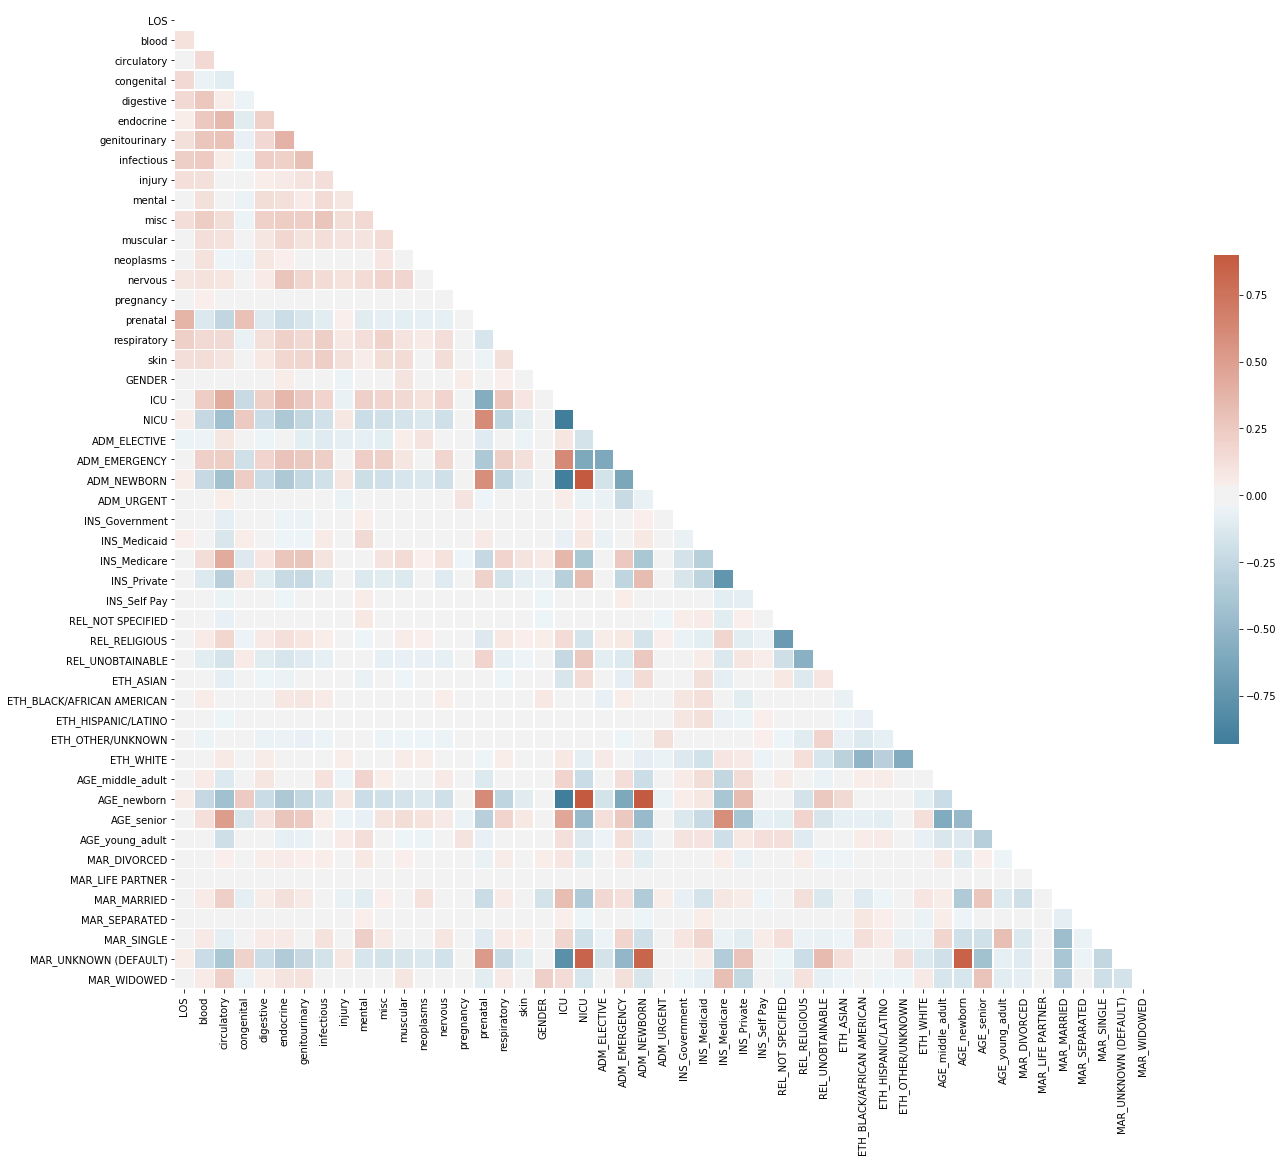

In [53]:
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 2.0 Build Models 

In [54]:
averageLOS = np.mean(y_test)
medianLOS = np.median(y_test)
print("AVG LOS RMSE:", mean_squared_error([averageLOS for _ in range(len(y_test))], y_test)**0.5)
print("Median LOS RMSE:", mean_squared_error([medianLOS for _ in range(len(y_test))], y_test)**0.5)

AVG LOS RMSE: 12.090113218994066
Median LOS RMSE: 12.621980195543914


## 2.1.1 Linear Models: Lasso 


In [76]:
# Build Lasso Model 
LassoModel = LassoCV(cv=100, random_state=0).fit(X_train, y_train)

38
9.763671814902386


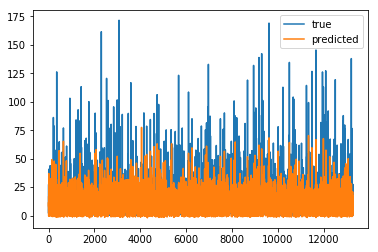

In [77]:
# Look at Chosen Variables 
print(np.count_nonzero(LassoModel.coef_))
# Calculate Model Error 
print((mean_squared_error(y_test, LassoModel.predict(X_test)))**(0.5))
plt.plot([i for i in range(len(y_test))], y_test, label="true")
plt.plot([i for i in range(len(y_test))], LassoModel.predict(X_test), label="predicted")
plt.legend()

## 2.1.1 Linear Models: OMP

In [78]:
#Build OMP Model 
OMPModel = OrthogonalMatchingPursuitCV(cv=100).fit(X_train, y_train)

5
Model RMSE: 10.008184010151808


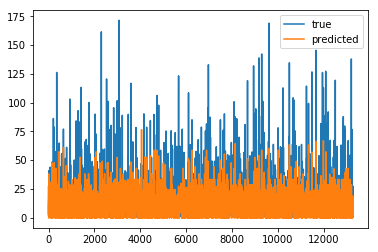

In [79]:
# Look at Chosen Variables 
print(np.count_nonzero(OMPModel.coef_))
# Calculate Model Error 
print("Model RMSE:", (mean_squared_error(y_test, OMPModel.predict(X_test)))**(0.5))
plt.plot([i for i in range(len(y_test))], y_test, label="true")
plt.plot([i for i in range(len(y_test))], OMPModel.predict(X_test), label="predicted")
plt.legend()

## 2.1.3 Linear Model: ElasticNet

In [88]:
# Build EN Model 
l1_ratios = np.linspace(0.001,1,100)
ENModel = ElasticNetCV(cv=100, l1_ratio=l1_ratios, random_state=0).fit(X_train, y_train)
# Calculate Model Error 
print("Model RMSE:", (mean_squared_error(y_test, ENModel.predict(X_test)))**(0.5))

Model RMSE: 9.763671814902386


## 2.2.1 Ensemble Model: GradientBoosting

In [75]:
#Build GB model 
for l2_regularization in [0, 0.1, 0.2, 0.5, 1, 1.5]:
    GBModel = HistGradientBoostingRegressor(l2_regularization=l2_regularization).fit(X_train, y_train)
    print("Model RMSE:", (mean_squared_error(y_test, GBModel.predict(X_test)))**(0.5))

Model RMSE: 9.051711142905424
Model RMSE: 9.0690676559968
Model RMSE: 9.053900113671517
Model RMSE: 9.027358971967717
Model RMSE: 9.038086485923781
Model RMSE: 9.05093120696254


Model RMSE: 9.094992801476812


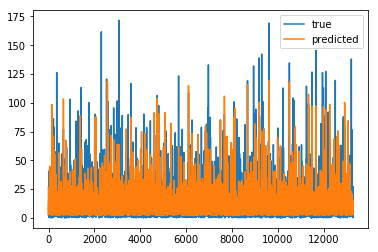

In [13]:
# Look at Chosen Variables 
# print(np.count_nonzero(GBModel.coef_))
# Calculate Model Error 
print("Model RMSE:", (mean_squared_error(y_test, GBModel.predict(X_test)))**(0.5))
plt.plot([i for i in range(len(y_test))], y_test, label="true")
plt.plot([i for i in range(len(y_test))], GBModel.predict(X_test), label="predicted")
plt.legend()

## 2.2.2 Ensemble Model: Decision Tree Classifier

In [43]:
DTModel = DecisionTreeClassifier().fit(X_train, y_train)
print("Model RMSE:", (mean_squared_error(y_test, DTModel.predict(X_test)))**(0.5))

Model RMSE: 12.870995470814538


28996     7.0
35607     4.0
20881     6.0
8170     16.0
9217      4.0
11490    17.0
31788     5.0
28381     2.0
51980     1.0
41455     4.0
20445     7.0
51204     5.0
40783     7.0
21008    16.0
49173     9.0
15430    16.0
23427    10.0
43445     2.0
12353     5.0
13886     7.0
51965    21.0
42316     1.0
3618      9.0
56467    14.0
24655     3.0
55304    11.0
19282     1.0
16749     5.0
7980      8.0
25386     6.0
         ... 
52558    12.0
22710     6.0
5195     16.0
52135     4.0
34605     5.0
41329    13.0
1923      2.0
45548     7.0
22182     6.0
43723     5.0
10961     3.0
48797    34.0
35282    11.0
39718    10.0
48508    14.0
52691     6.0
36122     4.0
9340      7.0
47895     2.0
48387     6.0
52097    14.0
53185    13.0
58383    13.0
31147     7.0
56559     3.0
23210     4.0
7664      4.0
32106     1.0
47911     3.0
52022     8.0
Name: LOS, Length: 11266, dtype: float64

## 2.3.1 Neural Network 

In [85]:
for HLS in [30]: 
    MLPModel = MLPRegressor(hidden_layer_sizes=(HLS,HLS,HLS)).fit(X_train, y_train)
    print("Model RMSE:", (mean_squared_error(y_test, MLPModel.predict(X_test)))**(0.5))

Model RMSE: 9.379375554600939


C:\Users\osarwar\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
